<a href="https://colab.research.google.com/github/TIMEdilation584/JP_Loksatta_moving_hearts/blob/master/June_working_PSPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.5.0


## Loading the Dataset 

In [ ]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

# Dataset path
dataset_path = 'drive/My Drive/idd-lite/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

## Data Preparation 

In [ ]:
# Image size that we are going to use
(HEIGHT,WIDTH) = (128,128)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8

In [ ]:
# Reference -> https://docs.python.org/2/library/glob.html
# The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, 
# although results are returned in arbitrary order. 

TRAINSET_SIZE = len(glob(img_train+'*/*_image.jpg'))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(img_val+'*/*_image.jpg'))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1403 images.
The Validation Dataset contains 204 images.


In [ ]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files
# tf.data.Dataset.list_files returns a dataset of all files matching one or more glob patterns.

train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset =val_dataset.map(parse_image)

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/image/resize
# Resize images to the size specified

def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


# PSPNet from Scratch

In [ ]:
# A class to get the basic convolution block 
# convolution_layer -> batch_normalization -> activation
class BasicConvolutionBlock(tf.keras.Model):
    
    def __init__(self, filter_size, kernel_size, dilation_rate, alpha, block_number, initializer='he_normal'):
        super(BasicConvolutionBlock, self).__init__()
        self.block_number = block_number
        self.convolution_layer = Convolution2D(filter_size, kernel_size =  kernel_size, 
                                               dilation_rate = dilation_rate, padding = 'same',
                                               kernel_initializer = initializer)
        self.batch_normalization = BatchNormalization()
        self.activation = LeakyReLU(alpha = alpha)
        
    def call(self, inputs):
        conv_output = self.convolution_layer(inputs)
        norm_output = self.batch_normalization(conv_output)
        if(self.block_number >= 3):
            return norm_output
        activation_output = self.activation(norm_output)  
        return activation_output

In [ ]:
# A Building Block of Residual Network
class ConvolutionBlock(tf.keras.Model):
    
    def __init__(self, filters, initializer='he_normal'):     
        super(ConvolutionBlock, self).__init__()
        self.filters = filters
        self.basic_convolution_1 = BasicConvolutionBlock(self.filters[0], (1,1), (1,1), 0.2, 1)
        self.basic_convolution_2 = BasicConvolutionBlock(self.filters[1], (3,3), (2,2), 0.2, 2)
        self.basic_convolution_3 = BasicConvolutionBlock(self.filters[2], (1,1), (1,1), None, 3)
        self.skip_convolution = BasicConvolutionBlock(self.filters[2], (3,3), (1,1), None, 4)
        # Last Block
        self.add_layer = Add()
        self.relu_activation = ReLU()
     
    def call(self, inputs):
        skip_input = inputs
        output_conv_1 = self.basic_convolution_1(inputs)
        output_conv_2 = self.basic_convolution_2(output_conv_1)
        output_conv_3 = self.basic_convolution_3(output_conv_2)
        output_skip_conv = self.skip_convolution(skip_input)
        # Last Block
        add_output = self.add_layer([output_conv_3,output_skip_conv])
        output = self.relu_activation(add_output)
        return output

In [ ]:
# Encoder block for PSPNet Net
class EncoderBlock(tf.keras.Model):
    
    def __init__(self, filters):
        super(EncoderBlock, self).__init__()
        self.filters = filters
        self.convolution_block_1 = ConvolutionBlock(self.filters[0])
        self.convolution_block_2 = ConvolutionBlock(self.filters[1])
        self.convolution_block_3 = ConvolutionBlock(self.filters[2])
        self.convolution_block_4 = ConvolutionBlock(self.filters[3])
        
    def call(self, inputs):     
        output_block_1 = self.convolution_block_1(inputs)
        output_block_2 = self.convolution_block_2(output_block_1)
        output_block_3 = self.convolution_block_3(output_block_2) 
        output_block_4 = self.convolution_block_4(output_block_3)
        return output_block_4

In [ ]:
# This class returns the pyramid feature map for Pyramid Pooling module
# Pooling -> Convolution -> UpSampling
class PyramidFeatureMap(tf.keras.Model):
    
    def __init__(self, block, filter_size, unsampling_size, pool_size, interpolation='bilinear'):
        super(PyramidFeatureMap, self).__init__()
        self.block = block
        self.convolution_layer = Convolution2D(filter_size, kernel_size = (1,1))
        self.upsampling_layer = UpSampling2D(unsampling_size, interpolation = interpolation)
        self.average_pooling = AveragePooling2D(pool_size)
        self.global_average_pooling = GlobalAveragePooling2D()
        
    def call(self,inputs):
        if(self.block=='red'):
            pool_output = self.global_average_pooling(inputs)
            pool_output = Reshape((1,1,512))(pool_output)
        else:
            pool_output = self.average_pooling(inputs)
        conv_output = self.convolution_layer(pool_output)
        upsampling_output = self.upsampling_layer(conv_output)
        return upsampling_output        

In [ ]:
# This class builds the Pyramid Pooling Module
# It builds the 4 feature maps and then concatenates all of them with the input
class PyramidPoolingModule(tf.keras.Model):
    
    def __init__(self):
        super(PyramidPoolingModule, self).__init__()
        self.block_red = PyramidFeatureMap('red', 64, (128,128), (1,1))
        self.block_yellow = PyramidFeatureMap('yellow', 64, 2, (2,2))
        self.block_blue = PyramidFeatureMap('blue', 64, 4, (4,4))
        self.block_green = PyramidFeatureMap('green', 64, 8, (8,8))
        
    def call(self,inputs):
        red_output = self.block_red(inputs)
        yellow_output = self.block_yellow(inputs)
        blue_output = self.block_blue(inputs)
        green_output = self.block_green(inputs)
        merged = concatenate([inputs, red_output, yellow_output, blue_output, green_output])
        return merged  

In [ ]:
# This block is for the last stage
# It gets the output of Pyramid Pooling Module and then performs convolution operation
# Pyramid Pooling -> Convolution -> Batch Normalization -> Softmax activation
class DecoderBlock(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(DecoderBlock, self).__init__()
        self.pyramid_pooling_module = PyramidPoolingModule()
        self.convolution_layer = Convolution2D(num_classes, kernel_size = (3,3), padding = 'same')
        self.batch_norm_layer = BatchNormalization()
        self.activation = Activation('softmax')
    
    def call(self, inputs):
        merged = self.pyramid_pooling_module(inputs)
        conv_output = self.convolution_layer(merged)
        norm_output = self.batch_norm_layer(conv_output)
        output = self.activation(norm_output)
        return output

In [ ]:
#This final class for the Model
class PSPNetModel(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(PSPNetModel, self).__init__()
        self.encoder = EncoderBlock([[32,32,64],[64,64,128],[128,128,256],[256,256,512]])
        self.decoder = DecoderBlock(num_classes)
        
    def call(self, inputs):
        encoder_output = self.encoder(inputs)
        final_output = self.decoder(encoder_output)
        return final_output

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from tensorflow.keras.layers import *
# SegmentationModel object
model = PSPNetModel(N_CLASSES)

In [ ]:
# Defining a loss object and an optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, 'tf_ckpts/', max_to_keep=3)

In [ ]:
# Define the metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
# Reference -> https://github.com/junhoning/machine_learning_tutorial/blob/b20b8a10438ec3e62f08f920744cc8ea854cde91/Visualization%20%26%20TensorBoard/%5BTensorBoard%5D%20Semantic%20Segmentation.ipynb

@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)
    
def train_and_checkpoint(model, manager, dataset, epoch):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    for (x_train, y_train) in dataset['train'].take(math.ceil(1403/8)):
        train_step(model, optimizer, x_train, y_train)
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))
    
@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)
    return predictions

In [ ]:
train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
# This variable will help to save the best model if its performance increases after an epoch   
highest_accuracy = 0

# Training the model for 40 epochs
for epoch in range(50):

    print("Epoch ",epoch+1)
    
    # Getting the current time before starting the training
    # This will help to keep track of how much time an epoch took
    start = time.time()
    
    train_and_checkpoint(model, manager, dataset, epoch+1)
    
    # Saving the train loss and train accuracy metric for TensorBoard visualization
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())
    
    # Validation phase
    for (x_test, y_test) in dataset['val'].take(math.ceil(204/8)):
        pred = test_step(model, x_test, y_test)
    
    # Saving the validation loss and validation accuracy metric for Tensorboard visualization
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())
    
    # Calculating the time it took for the entire epoch to run
    print("Time taken ",time.time()-start)
    
    # Printing the metrics for the epoch
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(), 
                            train_accuracy.result()*100,
                            test_loss.result(), 
                            test_accuracy.result()*100))
    
    # If accuracy has increased in this epoch, updating the highest accuracy and saving the model
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('pspnet_weights-epoch-{}.hdf5'.format(epoch+1))

    print('_'*80)

    # Reset metrics after every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Epoch  1
Initializing from scratch.
Saved checkpoint for epoch 1: tf_ckpts/ckpt-1
Time taken  269.3935046195984
Epoch 1, Loss: 1.319, Accuracy: 58.133, Val Loss: 1.334, Val Accuracy: 60.437
Validation accuracy increased from 0.000 to 60.437. Saving model weights.
________________________________________________________________________________
Epoch  2
Restored from tf_ckpts/ckpt-1
Saved checkpoint for epoch 2: tf_ckpts/ckpt-2
Time taken  11.983951807022095
Epoch 2, Loss: 1.113, Accuracy: 64.587, Val Loss: 1.163, Val Accuracy: 63.476
Validation accuracy increased from 60.437 to 63.476. Saving model weights.
________________________________________________________________________________
Epoch  3
Restored from tf_ckpts/ckpt-2
Saved checkpoint for epoch 3: tf_ckpts/ckpt-3
Time taken  12.168817281723022
Epoch 3, Loss: 1.020, Accuracy: 66.099, Val Loss: 1.106, Val Accuracy: 60.912
________________________________________________________________________________
Epoch  4
Restored from tf_ckpt

In [ ]:
from IPython.core.display import Image, display
display(Image('From scratch.png'))

In [ ]:
# Loading the weights of the best model
model.load_weights('pspnet_weights-epoch-41.hdf5')

In [ ]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of 
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    #display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 8
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        #print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    #print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

### Validation mIoU for PSPNet from scratch

In [ ]:
img_val = dataset_path + 'leftImg8bit/val/'
val_paths = glob(img_val+'*/*_image.jpg')

In [ ]:
mIoU = []
for path in val_paths:
    true_mask, pred_mask = predict(model,path)
    mIoU.append(IoU(true_mask, pred_mask))

In [ ]:
print("Validation mIoU = ",sum(mIoU)/len(mIoU))

Validation mIoU =  0.24356363447025353


# PSPNet with a pretrained Encoder

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# This class returns the pyramid feature map for Pyramid Pooling module
# Pooling -> Convolution -> UpSampling
class PyramidFeatureMap(tf.keras.Model):
    
    def __init__(self, block, filter_size, unsampling_size, pool_size, interpolation='bilinear'):
        super(PyramidFeatureMap, self).__init__()
        self.block = block
        self.convolution_layer = Convolution2D(filter_size, kernel_size = (1,1))
        self.upsampling_layer = UpSampling2D(unsampling_size, interpolation = interpolation)
        self.average_pooling = AveragePooling2D(pool_size)
        self.global_average_pooling = GlobalAveragePooling2D()
        
    def call(self,inputs):
        if(self.block=='red'):
            pool_output = self.global_average_pooling(inputs)
            pool_output = Reshape((1,1,2048))(pool_output)
        else:
            pool_output = self.average_pooling(inputs)
        conv_output = self.convolution_layer(pool_output)
        upsampling_output = self.upsampling_layer(conv_output)
        return upsampling_output        

In [ ]:
# This class builds the Pyramid Pooling Module
# It builds the 4 feature maps and then concatenates all of them with the input
class PyramidPoolingModule(tf.keras.Model):
    
    def __init__(self):
        super(PyramidPoolingModule, self).__init__()
        self.block_red = PyramidFeatureMap('red', 64, 8, (1,1))
        self.block_yellow = PyramidFeatureMap('yellow', 64, 2, (2,2))
        self.block_blue = PyramidFeatureMap('blue', 64, 4, (3,3))
        self.block_green = PyramidFeatureMap('green', 64, 8, (6,6))
        
    def call(self,inputs):
        red_output = self.block_red(inputs)
        yellow_output = self.block_yellow(inputs)
        blue_output = self.block_blue(inputs)
        green_output = self.block_green(inputs)
        merged = concatenate([inputs, red_output, yellow_output, blue_output, green_output])
        return merged  

In [ ]:
# This block is for the last stage
# It gets the output of Pyramid Pooling Module and then performs convolution operation
# Pyramid Pooling -> Convolution -> Batch Normalization -> Softmax activation
class DecoderBlock(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(DecoderBlock, self).__init__()
        self.pyramid_pooling_module = PyramidPoolingModule()
        self.convolution_layer = Convolution2D(num_classes, kernel_size = (3,3), padding = 'same')
        self.batch_norm_layer = BatchNormalization()
        self.activation = Activation('softmax')
    
    def call(self, inputs):
        merged = self.pyramid_pooling_module(inputs)
        conv_output = self.convolution_layer(merged)
        norm_output = self.batch_norm_layer(conv_output)
        output = self.activation(norm_output)
        return output

In [ ]:
#This final class for the Model
class PSPNetModel(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(PSPNetModel, self).__init__()
        self.resnet = ResNet50(weights='imagenet', include_top = False, input_shape = (128,128,3))
        for layer in self.resnet.layers:
            layer.trainable = False
        self.upsampling_encoder = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsampling = UpSampling2D(size=(16,16), interpolation='bilinear')
        self.decoder = DecoderBlock(num_classes)
        
    def call(self, inputs):
        encoder_output = self.resnet(inputs)
        encoder_output = self.upsampling_encoder(encoder_output)
        decoder_output = self.decoder(encoder_output)
        final_output = self.upsampling(decoder_output)
        return final_output

In [ ]:
from tensorflow.keras.layers import *
# SegmentationModel object
model = PSPNetModel(N_CLASSES)

In [ ]:
# Defining a loss object and an optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, 'tf_ckpts/', max_to_keep=3)

In [ ]:
# Define the metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
# Reference -> https://github.com/junhoning/machine_learning_tutorial/blob/b20b8a10438ec3e62f08f920744cc8ea854cde91/Visualization%20%26%20TensorBoard/%5BTensorBoard%5D%20Semantic%20Segmentation.ipynb

@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)
    
def train_and_checkpoint(model, manager, dataset, epoch):
    '''
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")'''
    for (x_train, y_train) in dataset['train'].take(math.ceil(1403/16)):
        train_step(model, optimizer, x_train, y_train)
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))
    
@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)
    return predictions

In [ ]:
train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
# This variable will help to save the best model if its performance increases after an epoch   
highest_accuracy = 0

# Training the model for 50 epochs
for epoch in range(50):

    print("Epoch ",epoch+1)
    
    # Getting the current time before starting the training
    # This will help to keep track of how much time an epoch took
    start = time.time()
    
    train_and_checkpoint(model, manager, dataset, epoch+1)
    
    # Saving the train loss and train accuracy metric for TensorBoard visualization
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())
    
    # Validation phase
    for (x_test, y_test) in dataset['val'].take(math.ceil(204/16)):
        pred = test_step(model, x_test, y_test)
    
    # Saving the validation loss and validation accuracy metric for Tensorboard visualization
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())
    
    # Calculating the time it took for the entire epoch to run
    print("Time taken ",time.time()-start)
    
    # Printing the metrics for the epoch
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(), 
                            train_accuracy.result()*100,
                            test_loss.result(), 
                            test_accuracy.result()*100))
    
    # If accuracy has increased in this epoch, updating the highest accuracy and saving the model
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('pspnet_weights-epoch-{}.hdf5'.format(epoch+1))

    print('_'*80)

    # Reset metrics after every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Epoch  1
Saved checkpoint for epoch 1: tf_ckpts/ckpt-1
Time taken  11.591219425201416
Epoch 1, Loss: 1.405, Accuracy: 55.695, Val Loss: 1.397, Val Accuracy: 54.426
Validation accuracy increased from 0.000 to 54.426. Saving model weights.
________________________________________________________________________________
Epoch  2
Saved checkpoint for epoch 2: tf_ckpts/ckpt-2
Time taken  7.210581541061401
Epoch 2, Loss: 1.222, Accuracy: 62.237, Val Loss: 1.185, Val Accuracy: 61.691
Validation accuracy increased from 54.426 to 61.691. Saving model weights.
________________________________________________________________________________
Epoch  3
Saved checkpoint for epoch 3: tf_ckpts/ckpt-3
Time taken  7.408657789230347
Epoch 3, Loss: 1.139, Accuracy: 64.068, Val Loss: 1.180, Val Accuracy: 63.452
Validation accuracy increased from 61.691 to 63.452. Saving model weights.
________________________________________________________________________________
Epoch  4
Saved checkpoint for epoch 4: tf_c

In [ ]:
display(Image('Pretrained Encoder.png'))

In [ ]:
# Loading the weights of the best model
model.load_weights('pspnet_weights-epoch-40.hdf5')

In [ ]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of 
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    #display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 8
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        #print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    #print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

### Validation mIoU for PSPNet with Pretrained Encoder  

In [ ]:
img_val = dataset_path + 'leftImg8bit/val/'
val_paths = glob(img_val+'*/*_image.jpg')

In [ ]:
mIoU = []
for path in val_paths:
    true_mask, pred_mask = predict(model,path)
    mIoU.append(IoU(true_mask, pred_mask))

In [ ]:
print("Validation mIoU = ",sum(mIoU)/len(mIoU))

Validation mIoU =  0.24133502200990242


# Importing PSPNet from existing official models

In [ ]:
import shutil
import tensorflow as tf
from tqdm import tqdm

for i in tqdm(train_paths):
    img = i.split('/')[-1]
    shutil.copy(i,'dataset_train/'+img)
    mask_path = tf.strings.regex_replace(i, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    mask = img.split('_')[0]+'_label.png'
    shutil.copy(mask_path.numpy(),'dataset_train/'+mask)

In [ ]:
for i in tqdm(val_paths):
    img = i.split('/')[-1]
    shutil.copy(i,'dataset_val/'+img)
    mask_path = tf.strings.regex_replace(i, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    mask = img.split('_')[0]+'_label.png'
    shutil.copy(mask_path.numpy(),'dataset_val/'+mask)

100%|██████████| 204/204 [04:46<00:00,  1.40s/it]


In [ ]:
# here dir_path is the route directory where all the images and segmentation maps are there
train_path = "dataset_train"
X_train = []
for i in os.listdir(train_path):
    X_train.append(i.split('.')[0])

val_path = "dataset_val"
X_test = []
for i in os.listdir(val_path):
    X_test.append(i.split('.')[0])

In [ ]:
!pip install segmentation-models

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import PSPNet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = PSPNet('resnet34', encoder_weights='imagenet', classes=8, activation='softmax', input_shape=(192,192,3))

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 192, 192, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 198, 198, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 96, 96, 64)   9408        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(img):
    img = img/255
    return img

class Dataset:
    
    CLASSES = [0,1,2,3,4,5,6,7]
    
    def __init__(self, directory, img_files,  classes):
        
        self.img_ids = img_files
        self.images_fps   = [os.path.join(directory, image_id.split('_')[0]+'_image.jpg') for image_id in self.img_ids]
        self.masks_fps    = [os.path.join(directory, image_id.split('_')[0]+'_label.png') for image_id in self.img_ids]
        self.class_values = [0,1,2,3,4,5,6,7]
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image = np.float32(cv2.resize(image,(192,192)))
        mask = np.float32(cv2.resize(mask,(192,192)))
        mask[mask==255] = 7
        image = normalize_image(image)

        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)

        return image, image_mask
        
    def __len__(self):
        return len(self.img_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):       
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=['accuracy',iou_score])

In [ ]:
# Dataset for train images
CLASSES = ['Drivable', 'Non_Drivable', 'Living_things', 'Vehicles', 'Road_side_objects', 'Far_objects', 'Sky', 'Other']
    
train_dataset = Dataset(train_path, X_train, classes=CLASSES)
test_dataset  = Dataset(val_path, X_test, classes=CLASSES)

In [ ]:
train_dataloader = Dataloder(train_dataset, batch_size=16, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (16, 192, 192, 3)
assert train_dataloader[0][1].shape == (16, 192, 192, 8)

(16, 192, 192, 3)


In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=50,\
                              validation_data=test_dataloader)

Epoch 1/50
172/172 [==============================] - 56s 324ms/step - loss: 0.6927 - accuracy: 0.7007 - iou_score: 0.3307 - val_loss: 1.1258 - val_accuracy: 0.3242 - val_iou_score: 0.0811
Epoch 2/50
172/172 [==============================] - 50s 292ms/step - loss: 0.5616 - accuracy: 0.7755 - iou_score: 0.4275 - val_loss: 1.3182 - val_accuracy: 0.3515 - val_iou_score: 0.0993
Epoch 3/50
172/172 [==============================] - 50s 292ms/step - loss: 0.5139 - accuracy: 0.7985 - iou_score: 0.4656 - val_loss: 1.1319 - val_accuracy: 0.4567 - val_iou_score: 0.1664
Epoch 4/50
172/172 [==============================] - 50s 293ms/step - loss: 0.4784 - accuracy: 0.8138 - iou_score: 0.4964 - val_loss: 0.7648 - val_accuracy: 0.6318 - val_iou_score: 0.3004
Epoch 5/50
172/172 [==============================] - 50s 293ms/step - loss: 0.4549 - accuracy: 0.8233 - iou_score: 0.5180 - val_loss: 0.5992 - val_accuracy: 0.7234 - val_iou_score: 0.4027
Epoch 6/50
172/172 [==============================] - 5

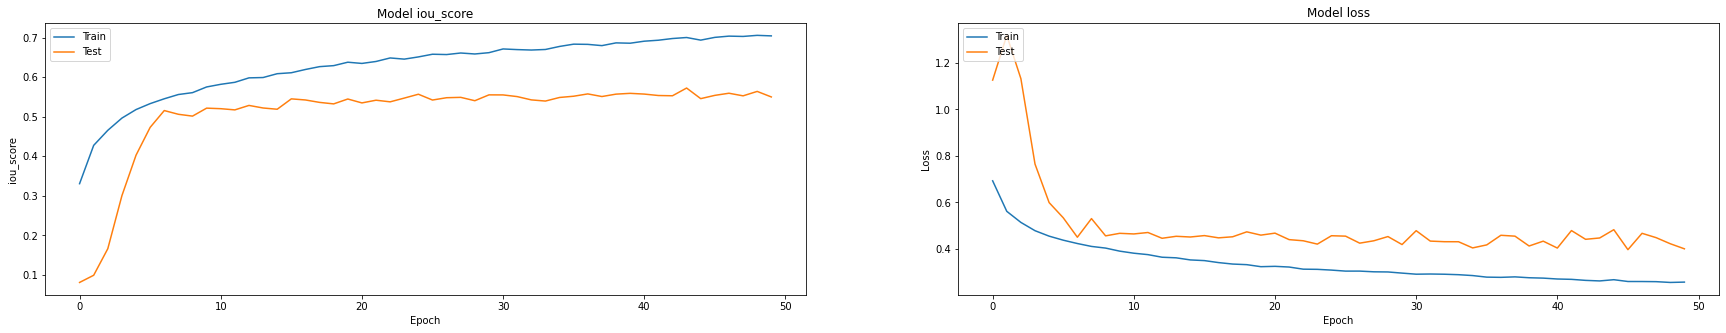

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
HEIGHT = 192
WIDTH = 192

def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 8
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        #print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    #print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [ ]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of 
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model.predict_on_batch(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    #display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

### Validation mIoU for PSPNet imported model 

In [ ]:
img_val = dataset_path + 'leftImg8bit/val/'
val_paths = glob(img_val+'*/*_image.jpg')

In [ ]:
mIoU = []
for path in val_paths:
    true_mask, pred_mask = predict(model,path)
    mIoU.append(IoU(true_mask, pred_mask))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print("Validation mIoU Score : ",sum(mIoU)/len(mIoU))

Validation mIoU Score :  0.363701048404907


# Observations

In [ ]:
from prettytable import PrettyTable

# Representing results in a table
pt = PrettyTable()

pt.field_names = ["Model", "Highest Train Accuracy", "Highest Validation Accuracy", "Validation mIoU"]
pt.add_row(["PSPNet (from Scratch)",'89.76 %','80.80 %',0.43338])
pt.add_row(["PSPNet with a Pretrained Encoder",'69.438 %','66.919 %',0.24952])
pt.add_row(["PSPNet (from official models)",'89.91 %','83.08 %', 0.36370])
print(pt)            

+----------------------------------+------------------------+-----------------------------+-----------------+
|              Model               | Highest Train Accuracy | Highest Validation Accuracy | Validation mIoU |
+----------------------------------+------------------------+-----------------------------+-----------------+
|      PSPNet (from Scratch)       |        89.76 %         |           80.80 %           |     0.43338     |
| PSPNet with a Pretrained Encoder |        69.438 %        |           66.919 %          |     0.24952     |
|  PSPNet (from official models)   |        89.91 %         |           83.08 %           |      0.3637     |
+----------------------------------+------------------------+-----------------------------+-----------------+


* The best results are found using PSPNet from Scratch model.
* When we train PSPNet using a pretrained encoder, the results fluctuate a lot and the validation mIoU is very low as well.
* While using the official model, we get a high validation accuracy, but the validation mIoU score is low.